In [66]:
import pandas
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
from scipy.stats import sem
import numpy 
import scipy
    

column_names=["length_A", "length_B", "abs_difference_percent", "answer", "answer_correct", "duration"]
df = pandas.read_csv("data/rcg_test.csv", names=column_names)

df['difference_A_minus_B'] = df['length_A'] - df['length_B']
df['distance_min'] = df[['length_A', "length_B"]].min(axis=1)
df['difference_relative'] = df['difference_A_minus_B']/df['distance_min']

print(df.head(3))

   length_A  length_B  abs_difference_percent  answer  answer_correct  \
0   501.085   517.129                3.201830       0               1   
1   528.139   487.183                8.406660       1               1   
2   505.785   501.783                0.797549       0               0   

   duration  difference_A_minus_B  distance_min  difference_relative  
0     0.950               -16.044       501.085            -0.032019  
1     1.050                40.956       487.183             0.084067  
2     1.187                 4.002       501.783             0.007976  


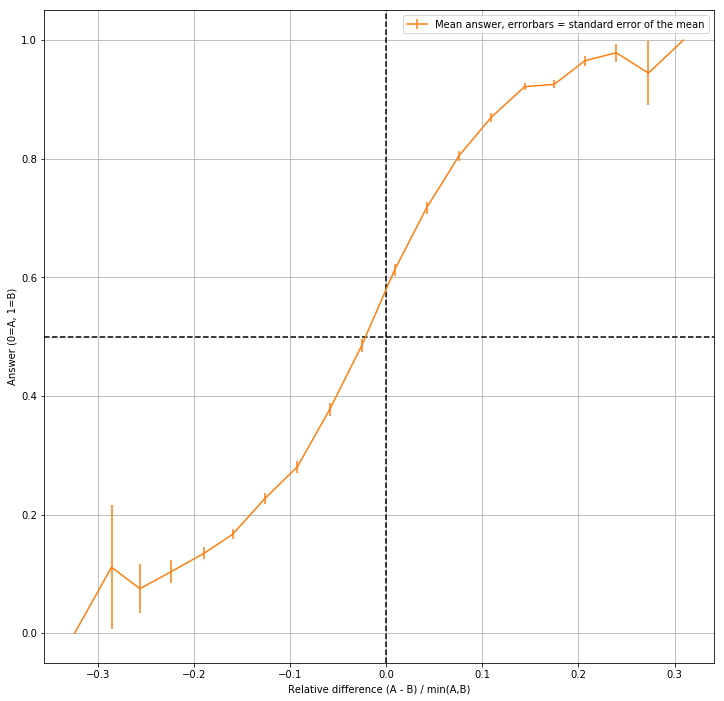

In [68]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111)

n_bins = 20

rel_diff_range_param = 3
df_f = df[(df['difference_relative'] < rel_diff_range_param).values * (df['difference_relative'] > -rel_diff_range_param).values]

bin_centers, bin_edges, _binnumbers = binned_statistic(df_f['difference_relative'].values,df_f['difference_relative'].values, statistic="mean", bins=n_bins)
bin_means, bin_edges, _binnumbers = binned_statistic(df_f['difference_relative'].values,df_f['answer'].values, statistic="mean", bins=n_bins)
bin_stds, bin_edges, _binnumbers = binned_statistic(df_f['difference_relative'].values,df_f['answer'].values, statistic="std", bins=n_bins)
bin_counts, bin_edges, _binnumbers = binned_statistic(df_f['difference_relative'].values,df_f['answer'].values, statistic="count", bins=n_bins)
bin_sems = bin_stds / np.sqrt(bin_counts)

ax.errorbar(bin_centers, bin_means, yerr=bin_sems, color="C1", label="Mean answer, errorbars = standard error of the mean")
ax.set_xlabel('Relative difference (A - B) / min(A,B)')
ax.set_ylabel('Answer (0=A, 1=B)')
ax.axhline(0.5, color='k', ls="--")
ax.axvline(0.0, color='k', ls="--")
ax.legend(loc="best")
ax.grid()
# ax.set_xlim(-0.1, 0.1)
plt.show()

Plotting some statistics
-----------------------

/Users/rmkujala/anaconda/envs/routechoicegame/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


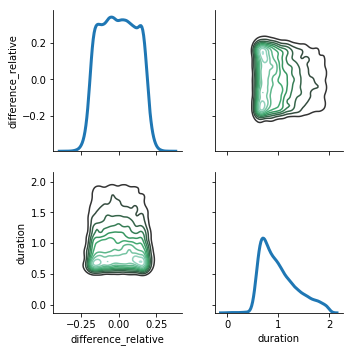

In [69]:
import seaborn as sns

df_filtered = df[df['duration'] < 2]
g = sns.PairGrid(df_filtered[['difference_relative', 'duration']])
g.map_lower(sns.kdeplot)
g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3)
plt.show()

"Fitting the line" using Bayesian modeling and Stan
------------------------------------------------

It seems that when relative difference $R$ (a random variable) falls between [-0.1, 0.1] the probability for choosing alternative B can be approximated by $p(answer=B|R=r) \approx y_0 + s \cdot r$, where $s$ is the slope of the line and $y_0$ is the point where the line intercepts the y-axis. 

Without binning the data, one cannot fit such a line to the original data. As there is no well-principled solution for picking the number of bins one should opt for a more principled solution. For this, Bayesian modeling is useful as it enables us to directly estimate the parameters $y_0$ and $s$ (and consequently also the x-intercept $x_0$) based on the observed data. While the most likely values for $y_0$ and $s$ can be estimated without Bayesian modeling e.g. by  likelihood maximization, Bayesian modeling can also provide reasonable error bounds for the parameters. 

For applying Bayesian modeling, we first have to quantify our a priori beliefs on the values of parameters $s$ and $y_\text{intercept}$.
For now, let us assume that we only know that $s$ resides within (-20,20) and $y_\text{intercept}$ redises within (0,1). Opting for uninformative prior distributions, we will assume that $P(s) ~ \text{Uniform}(-20,20)$, and $P(y_\text{intercept})~\text{Uniform}(0,1)$.
 
Now let $r$ be the vector of relative differences, with $r^i$ being the relative difference for the $i$th data point. Further, let $a$ be the vector of users answers with $a^i$ being the $i$th answer (that corresponds to $r^i$). Now, the *Bayes-rule* states that (using a simple rule of conditional probabilities) that

$P(s,y_0|a,r) = \frac{P(a,r|s,y_0)P(s,y_0)}{P(a,r)}$

The posterior probability density function $P(s,y_0|a,r)$ then fully captures the uncertainty in our estimates of the parameters $s$ and $y_0$ after obesrving the data $a,r$. In other words, the data $a,r$ updates our *prior* beliefs on $P(s,y)$ to the *posterior* $P(s,y_0|a,r))$.

Initially, we assumed that our priors for $s$ and $y_0$ are independent: $P(s,y_0)=P(s)P(y_0)$. In the Bayes rule,  the term $P(a,r)$ does not depend on $s$ or $y_0$ and can thus be omitted. We can thus write:

$P(s,y_0|a,r) \propto P(a,r|s,y_0)P(s)P(y_0)$

Now, the term $P(a,r|s,y_0)$ is given by $P(a,r|s,y_0)=\prod_{i=1..N}P(a^i,r^i|s,y_0) = \prod_{i=1..N} (y_0 + s \cdot r^i)^{a^i}(1-y_0 + s \cdot r^i)^{1-a^i}=\prod_{i=1..N} (p^i)^{a^i}(1-p^i)^{1-a^i}=\prod_{i=1..N} \text{BernoulliPMF}_{p^i}(a^i)$. So our main equation now reads as:

$P(s,y_0|a,r) \propto \left( \prod_{i=1..N} (y_0 + s \cdot r^i)^{a^i} (1-y_0 + s \cdot r^i)^{1-a^i} \right) P(s)P(y_0)$


Based on the above equation, we could compute values for $P(s,y_0|A,R)$ up to a constant factor e.g. by sweeping through all possible parameter value combinations of $s$ and $y_0$. This 2-dimensional distribution then presentes our knowledge on the parameter values $s$ and $y_0$. This distribution could also be summarized different statistics such as mean, median, 95th percentile etc.

In practice the computation of all values of $P(s,y_0|A,R)$ is cumbersome due to computational reasons especially in cases where there are a large number of parameters to be estimated. (However, this is not necessarily the case here, as there are only two parameters in the model!) So, instead of looping through different values of $s$ and $y_0$, one uses computational methods for obtaining samples of the (posterior) distribution $P(s,y_0|A,R)$. Given these samples, it is then also easy to summarize the distribution using statistics such as mean, median, 95th percentile etc. 

Below, we do this latter approach using Stan (http://mc-stan.org/), which yields also conveniently estimates with confidence intervals for the $x_\text{intercept}$.


In [ ]:
import pystan

stan_linear_fit_code = """
data {
    int N; // number of samples
    vector[N] rdiff; // relative differences
    int answer[N]; // estimated treatment effects
}
parameters {
    real<lower=0, upper=1> y_intercept;
    real<lower=-20, upper=20> slope;
}
transformed parameters {
    real x_intercept = -(y_intercept-0.5)/slope; 
}
model {
    answer ~ bernoulli(y_intercept + slope * rdiff);
}
"""
sm = pystan.StanModel(model_code=stan_linear_fit_code)
print("compiled")

In [105]:
for rel_diff_range_param in [0.10]:
    df_filtered = df[(df['difference_relative'] < rel_diff_range_param).values * (df['difference_relative'] > -rel_diff_range_param).values]
    for frac in [0.01, 0.03, 0.1, 0.3, 1.0]:
        df_to_fit = df_filtered.sample(frac=frac)
        sampling_data = {
            'N': len(df_to_fit),
            'rdiff': df_to_fit["difference_relative"].values,
            'answer': df_to_fit["answer"].values
        }
        for n_iter in [1000, 10000]:
            print("-----------------------------------------------")
            print("Sampling using params", rel_diff_range_param, sampling_data['N'], frac, n_iter)
            fit = sm.sampling(data=sampling_data, iter=n_iter, chains=4)
            x_intercept = fit.extract()['x_intercept']
            print("Results for rel_diff_range " + str(rel_diff_range_param))
            # print(fit)
            print("Precise values (5th perc., median, 95th perc.) for the x_intercept:", numpy.percentile(x_intercept, [5, 50, 95]))
            print("Error margin", numpy.percentile(x_intercept, 95) - numpy.percentile(x_intercept, 5))
            print("-----------------------------------------------")


-----------------------------------------------
Sampling using params 0.1 125 0.01 1000
Results for rel_diff_range 0.1
Precise values (5th perc., median, 95th perc.) for the x_intercept: [-0.04238391 -0.02114944 -0.00391774]
Error margin 0.0384661658996
-----------------------------------------------
-----------------------------------------------
Sampling using params 0.1 125 0.01 10000
Results for rel_diff_range 0.1
Precise values (5th perc., median, 95th perc.) for the x_intercept: [-0.04575791 -0.02132448 -0.00454456]
Error margin 0.0412133491111
-----------------------------------------------
-----------------------------------------------
Sampling using params 0.1 375 0.03 1000
Results for rel_diff_range 0.1
Precise values (5th perc., median, 95th perc.) for the x_intercept: [-0.04444628 -0.02660542 -0.01258468]
Error margin 0.0318615992945
-----------------------------------------------
-----------------------------------------------
Sampling using params 0.1 375 0.03 10000
Resu

In [94]:
numpy.percentile( (fit.extract()['x_intercept'])

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec